In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from fwi_predict.constants import TZ_STRING

In [2]:
raw = pd.read_excel("../data/raw/export-457-measurements.xlsx")

### Clean column names

In [3]:
raw = raw.rename(columns=lambda s: s.lower() \
                                  .replace(' ', '_') \
                                  .replace('(', '') \
                                  .replace(')', '') \
                                  .replace('°', '') \
                                  .replace('?', '') \
                                  .replace('/', '_per_') \
                                  .replace('_per_l', '_per_L')) 


In [4]:
raw = raw.rename(columns={
  'sr._no': 'sample_idx',
  'date_of_data_collection': 'date',
  'time_of_data_collection': 'sample_time',
  'type': 'time_of_day',
  'turbidity_in_cm': 'turbidity_cm',
  'equipment': 'measure_instruments'
})

In [5]:
raw.columns

Index(['sample_idx', 'date', 'sample_time', 'pond_id', 'farmer', 'time_of_day',
       'is_follow_up', 'is_follow_up_possible',
       'reason_follow_up_not_possible', 'group', 'pond_status', 'observer',
       'measure_instruments', 'weather', 'do_mg_per_L', 'ph', 'turbidity_cm',
       'ammonia_mg_per_L', 'temp_in_c', 'tds_ppt', 'alkalinity_mg_per_L',
       'hardness_mg_per_L', 'water_color', 'is_wq_in_range',
       'parameters_out_of_range', 'corrective_actions_requested',
       'corrective_actions_requested_other',
       'corrective_actions_amount_requested', 'corrective_actions_implemented',
       'corrective_actions_implementation_date', 'corrective_actions_taken',
       'corrective_actions_taken_other', 'corrective_actions_taken_details',
       'non-prescribed_corrective_actions_taken', 'reason_not_implemented',
       'water_quality_improved_after_corrective_actions',
       'corrective_action_notes', 'individuals_air_gulping',
       'individuals_tail_splashing', 'dead_

#### Data exploration and cleaning

In [6]:
explore_ds = raw.copy()

In [7]:
len(explore_ds['sample_idx'].unique()) == len(explore_ds) # Check serial numbers are unique

True

Only keep measurements from treatment group and that aren't follow ups

In [8]:
explore_ds['pond_status'].value_counts(dropna=False)

pond_status
Treatment     5967
Control        358
Assessment     287
NaN             38
Name: count, dtype: int64

In [55]:
explore_ds['pond_status'].value_counts(dropna=False)
explore_ds = explore_ds[explore_ds['pond_status'] == 'Treatment']

In [56]:
explore_ds['follow_up'] = explore_ds['is_follow_up'].map(lambda s: False if s == 'No' else True)
explore_ds = explore_ds.drop(columns='is_follow_up')
explore_ds['follow_up'].value_counts(dropna=False)
explore_ds = explore_ds[~explore_ds['follow_up']]

In [57]:
explore_ds['date'] = pd.to_datetime(explore_ds['date'])
explore_ds['sample_dt'] = pd.to_datetime(explore_ds['date'].dt.strftime('%Y-%m-%d') + ' ' + explore_ds['sample_time'])
explore_ds['sample_dt'] = explore_ds['sample_dt'].dt.tz_localize(TZ_STRING)
explore_ds = explore_ds.drop(columns='date')

In [58]:
# Add hour column and sort by pond_id, date and hour
explore_ds['hour'] = explore_ds['sample_dt'].dt.hour
explore_ds['morning'] = explore_ds['hour'].between(3, 11)  # Morning measurements typically 3-11am
explore_ds = explore_ds.sort_values(['pond_id', 'sample_dt'])
explore_ds = explore_ds.drop(columns='time_of_day') # Might actually need this

C:\Users\squaade\AppData\Local\Temp\ipykernel_30928\341729067.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  explore_ds['month_year'] = explore_ds['sample_dt'].dt.to_period('M')


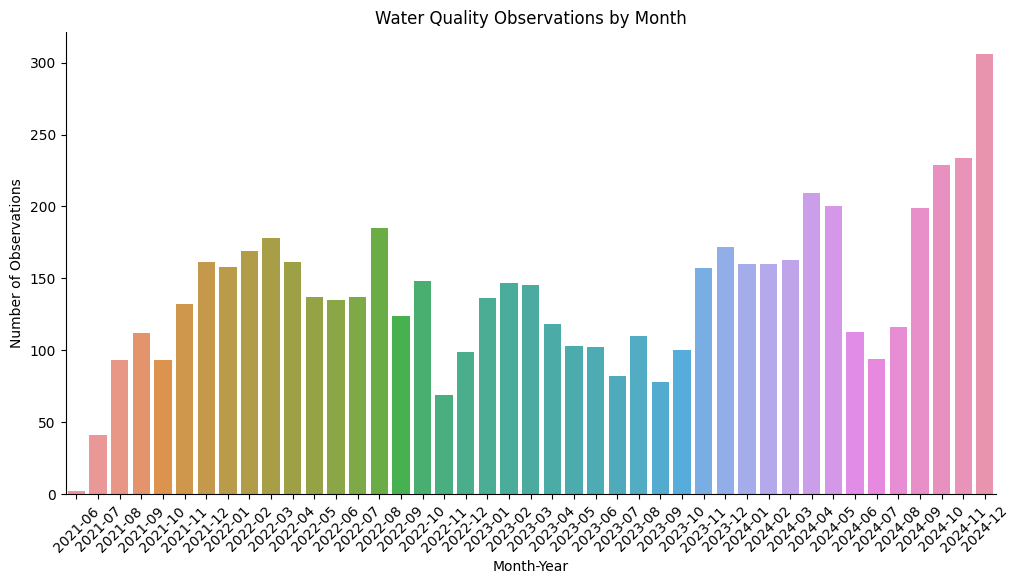

In [59]:
# Convert date to month-year and plot histogram
explore_ds['month_year'] = explore_ds['sample_dt'].dt.to_period('M')

plt.figure(figsize=(12, 6))
sns.barplot(x=explore_ds['month_year'].value_counts().sort_index().index,
            y=explore_ds['month_year'].value_counts().sort_index().values)

plt.xticks(rotation=45)
plt.title('Water Quality Observations by Month')
plt.xlabel('Month-Year')
plt.ylabel('Number of Observations')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


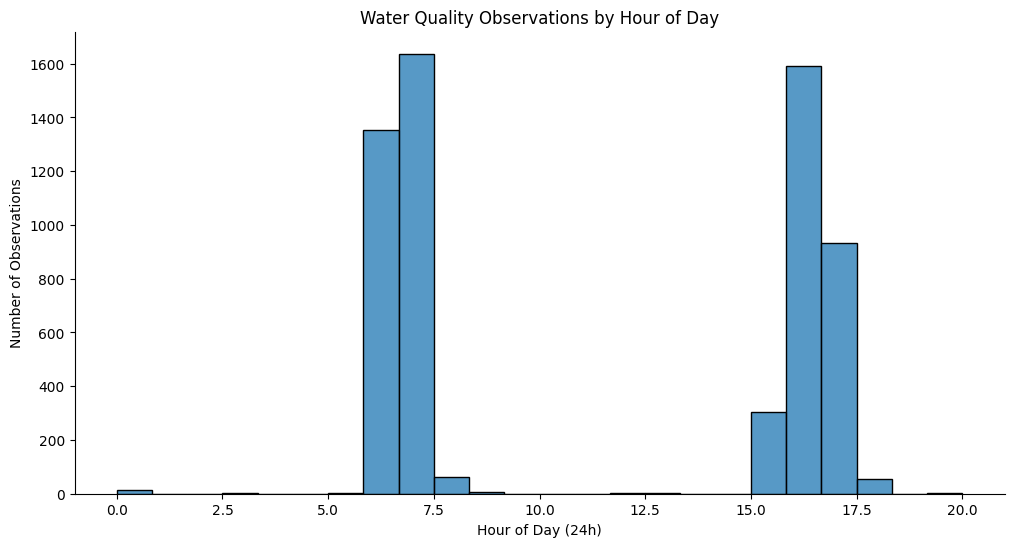

In [60]:
# Convert sample_time to hour and plot histogram
plt.figure(figsize=(12, 6))
sns.histplot(explore_ds, x='hour', bins=24)
plt.title('Water Quality Observations by Hour of Day')
plt.xlabel('Hour of Day (24h)')
plt.ylabel('Number of Observations')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

In [61]:
# Remove if wereport to be taken at midnight
midnight_time = explore_ds['sample_time'] == '00:00'
explore_ds[midnight_time]
print(len(explore_ds[midnight_time]))
explore_ds = explore_ds[explore_ds['hour'] != 0]

15


In [62]:
explore_ds['dead_fish'].value_counts(dropna=False)

dead_fish
NaN       3035
0.0       2885
1.0          5
3.0          5
5.0          3
2.0          2
80.0         2
200.0        2
15.0         2
7.0          1
4.0          1
1000.0       1
100.0        1
50.0         1
10.0         1
2200.0       1
6.0          1
60.0         1
120.0        1
150.0        1
Name: count, dtype: int64

In [63]:
explore_ds['species'].value_counts(dropna=False)

species
NaN                                   2909
Catla, Rohu                           1473
Rohu, Catla                           1022
Roopchand                              223
Rohu, Catla, Roopchand                 130
Rohu, Roopchand                         44
Rohu, Catla, Grass carp                 40
Rohu                                    27
Catla, Rohu, Roopchand                  20
Roopchand, Catla, Rohu                  19
Rohu, Catla, Pangasius                  12
Catla, Rohu, Grass carp                 12
Catla                                    6
Roopchand, Pangasius                     5
Rohu, Grass carp                         4
Whiteleg shrimp                          2
Rohu, Catla, Whiteleg shrimp             1
Catla, Grass carp                        1
Rohu, Catla, Grass carp, Pangasius       1
Catla, Pangasius                         1
Name: count, dtype: int64

In [64]:
explore_ds['species_catla'] = explore_ds['species'].str.contains('catla', case=False)
explore_ds['species_rohu'] = explore_ds['species'].str.contains('rohu', case=False)
explore_ds['species_roopchand'] = explore_ds['species'].str.contains('roopchand')
explore_ds['species_grass_carp'] = explore_ds['species'].str.contains('grass carp', case=False)
explore_ds['species_pangasius'] = explore_ds['species'].str.contains('pangasius', case=False)
explore_ds['species_whiteleg_shrimp'] = explore_ds['species'].str.contains('whiteleg shrimp', case=False)

explore_ds = explore_ds.drop(columns='species')

<Axes: >

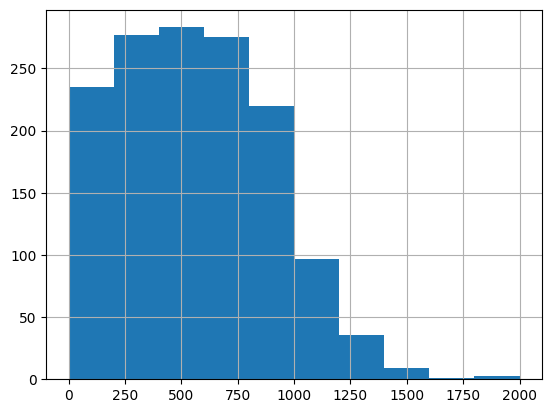

In [65]:
explore_ds['weight'].hist()

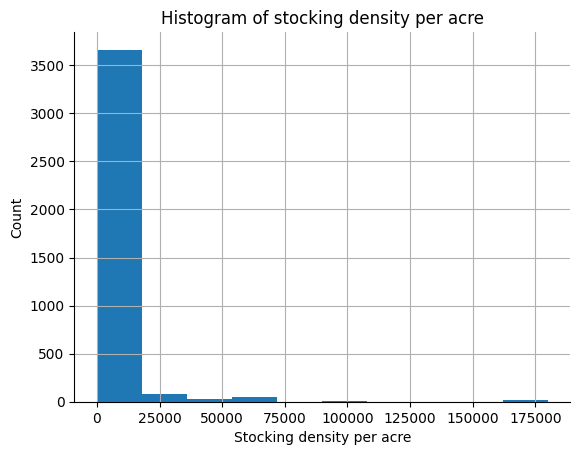

In [66]:
fig, ax = plt.subplots()
explore_ds['stocking_density_per_acre'].hist(ax=ax)
ax.set_xlabel('Stocking density per acre')
ax.set_ylabel('Count')
ax.set_title('Histogram of stocking density per acre')
ax.spines[['top', 'right']].set_visible(False)

There are more columns we can explore later if we were to take time series approach but sticking with simple quantitative for now.

In [67]:
explore_ds['feed_amount_kg'].value_counts(dropna=False)

feed_amount_kg
NaN       2738
30.0       195
60.0       188
40.0       160
100.0      157
          ... 
215.0        1
1155.0       1
1550.0       1
14.0         1
16.0         1
Name: count, Length: 146, dtype: int64

In [68]:
# Get previous measurement values from different day
prev_cols = ['sample_dt', 'do_mg_per_L', 'ph', 'turbidity_cm', 'ammonia_mg_per_L', 
             'individuals_air_gulping', 'individuals_tail_splashing',
             'dead_fish', 'feed_amount_kg', 'stocking_density_per_acre', 'weight']

prev_cols = prev_cols + explore_ds.columns[explore_ds.columns.str.contains('species_')].tolist()

# Create a date column without time
explore_ds['date_only'] = explore_ds['sample_dt'].dt.date

# Function to get previous values from different day
def get_prev_values(group):
    """
    Find previous measurements for each observation from a different day.
    
    For each observation, tries to find a previous measurement from the same time of day
    (morning/evening). If not available, uses any measurement from a previous day.
    Make sure the dataframe is sorted first.
    
    Parameters:
    -----------
    group : DataFrame
        Group of observations for a single pond, sorted by sample_dt
        
    Returns:
    --------
    DataFrame
        Group with added columns for previous measurements
    """
    # Process each row individually to properly handle previous day logic
    for i in range(len(group)):
        current_row = group.iloc[i:i+1]
        current_date = current_row['date_only'].iloc[0]
        current_morning = current_row['morning'].iloc[0]
        
        # Get all observations from previous days for this pond
        prev_day_rows = group[group['date_only'] < current_date]
        
        if len(prev_day_rows) > 0:
            # First try to match the same time of day (morning/evening)
            matching_time_rows = prev_day_rows[prev_day_rows['morning'] == current_morning]
            
            if len(matching_time_rows) > 0:
                # Use the most recent observation with matching time of day
                prev_row = matching_time_rows.iloc[-1]
                group.loc[current_row.index, 'prev_matches_time'] = True
            else:
                # If no matching time, use the most recent observation from any time
                prev_row = prev_day_rows.iloc[-1]
                group.loc[current_row.index, 'prev_matches_time'] = False
            
            # Store previous values for all columns
            for col in prev_cols:
                group.loc[current_row.index, f'prev_{col}'] = prev_row[col]
            
            # Calculate days since previous measurement
            group.loc[current_row.index, 'prev_sample_dt'] = prev_row['sample_dt']
    
    return group

# Apply function by pond
explore_ds = explore_ds.groupby('pond_id', group_keys=False).apply(get_prev_values)

# Calculate days between measurements 
explore_ds['days_since_prev'] = (explore_ds['sample_dt'] - explore_ds['prev_sample_dt']).dt.days

C:\Users\squaade\AppData\Local\Temp\ipykernel_30928\2969904212.py:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  group.loc[current_row.index, f'prev_{col}'] = prev_row[col]
C:\Users\squaade\AppData\Local\Temp\ipykernel_30928\2969904212.py:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  group.loc[current_row.index, f'prev_{col}'] = prev_row[col]
C:\Users\squaade\AppData\Local\Temp\ipykernel_30928\2969904212.py:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype 

In [69]:
explore_ds = explore_ds.sort_values(['pond_id', 'sample_dt'])
inspect_cols = ['pond_id', 'sample_dt', 'do_mg_per_L', 'prev_do_mg_per_L', 'prev_matches_time']
explore_ds.loc[explore_ds['prev_matches_time'] == False, inspect_cols]

,pond_id,sample_dt,do_mg_per_L,prev_do_mg_per_L,prev_matches_time
6271,NL-SKR1,2021-11-12 16:43:00+05:30,7.5,4.5,False
6501,NL-SRZ1,2021-09-01 17:50:00+05:30,4.8,1.5,False
776,WG-AAR1,2024-10-01 17:15:00+05:30,11.6,3.7,False
775,WG-AAR2,2024-10-01 17:25:00+05:30,11.1,4.1,False
1152,WG-ALS2,2024-07-11 16:27:00+05:30,9.6,4.3,False
3868,WG-BKR1,2023-01-19 15:52:00+05:30,8.3,3.1,False
989,WG-BSK1,2024-08-29 16:49:00+05:30,10.9,3.8,False
6564,WG-CBU1,2021-08-18 07:30:00+05:30,2.1,13.0,False
893,WG-CVR1,2024-09-13 16:40:00+05:30,9.1,3.2,False
895,WG-CVR2,2024-09-13 16:30:00+05:30,9.7,3.8,False


In [70]:
explore_ds.columns

Index(['sample_idx', 'sample_time', 'pond_id', 'farmer',
       'is_follow_up_possible', 'reason_follow_up_not_possible', 'group',
       'pond_status', 'observer', 'measure_instruments', 'weather',
       'do_mg_per_L', 'ph', 'turbidity_cm', 'ammonia_mg_per_L', 'temp_in_c',
       'tds_ppt', 'alkalinity_mg_per_L', 'hardness_mg_per_L', 'water_color',
       'is_wq_in_range', 'parameters_out_of_range',
       'corrective_actions_requested', 'corrective_actions_requested_other',
       'corrective_actions_amount_requested', 'corrective_actions_implemented',
       'corrective_actions_implementation_date', 'corrective_actions_taken',
       'corrective_actions_taken_other', 'corrective_actions_taken_details',
       'non-prescribed_corrective_actions_taken', 'reason_not_implemented',
       'water_quality_improved_after_corrective_actions',
       'corrective_action_notes', 'individuals_air_gulping',
       'individuals_tail_splashing', 'dead_fish', 'notes_mortalities',
       'self-initi

In [71]:
instruments = explore_ds['measure_instruments'].value_counts(dropna=False)
explore_ds['do_winkler'] = (
  explore_ds['measure_instruments'].str.contains('winkler', case=False) |
  explore_ds['measure_instruments'].str.contains('dss', case=False)
)
# Fix missing values
missing_fix = (
    (explore_ds['measure_instruments'].isna()) &
    (explore_ds['sample_dt'] > pd.Timestamp(year=2024, month=2, day=18, tz=TZ_STRING)) &
    (explore_ds['pond_id'].str[:2] == 'WG')
)
explore_ds.loc[missing_fix, 'do_winkler'] = True

In [72]:
explore_ds['do_winkler'].value_counts(dropna=False)

do_winkler
False    4524
True     1428
Name: count, dtype: int64

#### Check for duplicates

c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\squaade\Documents\

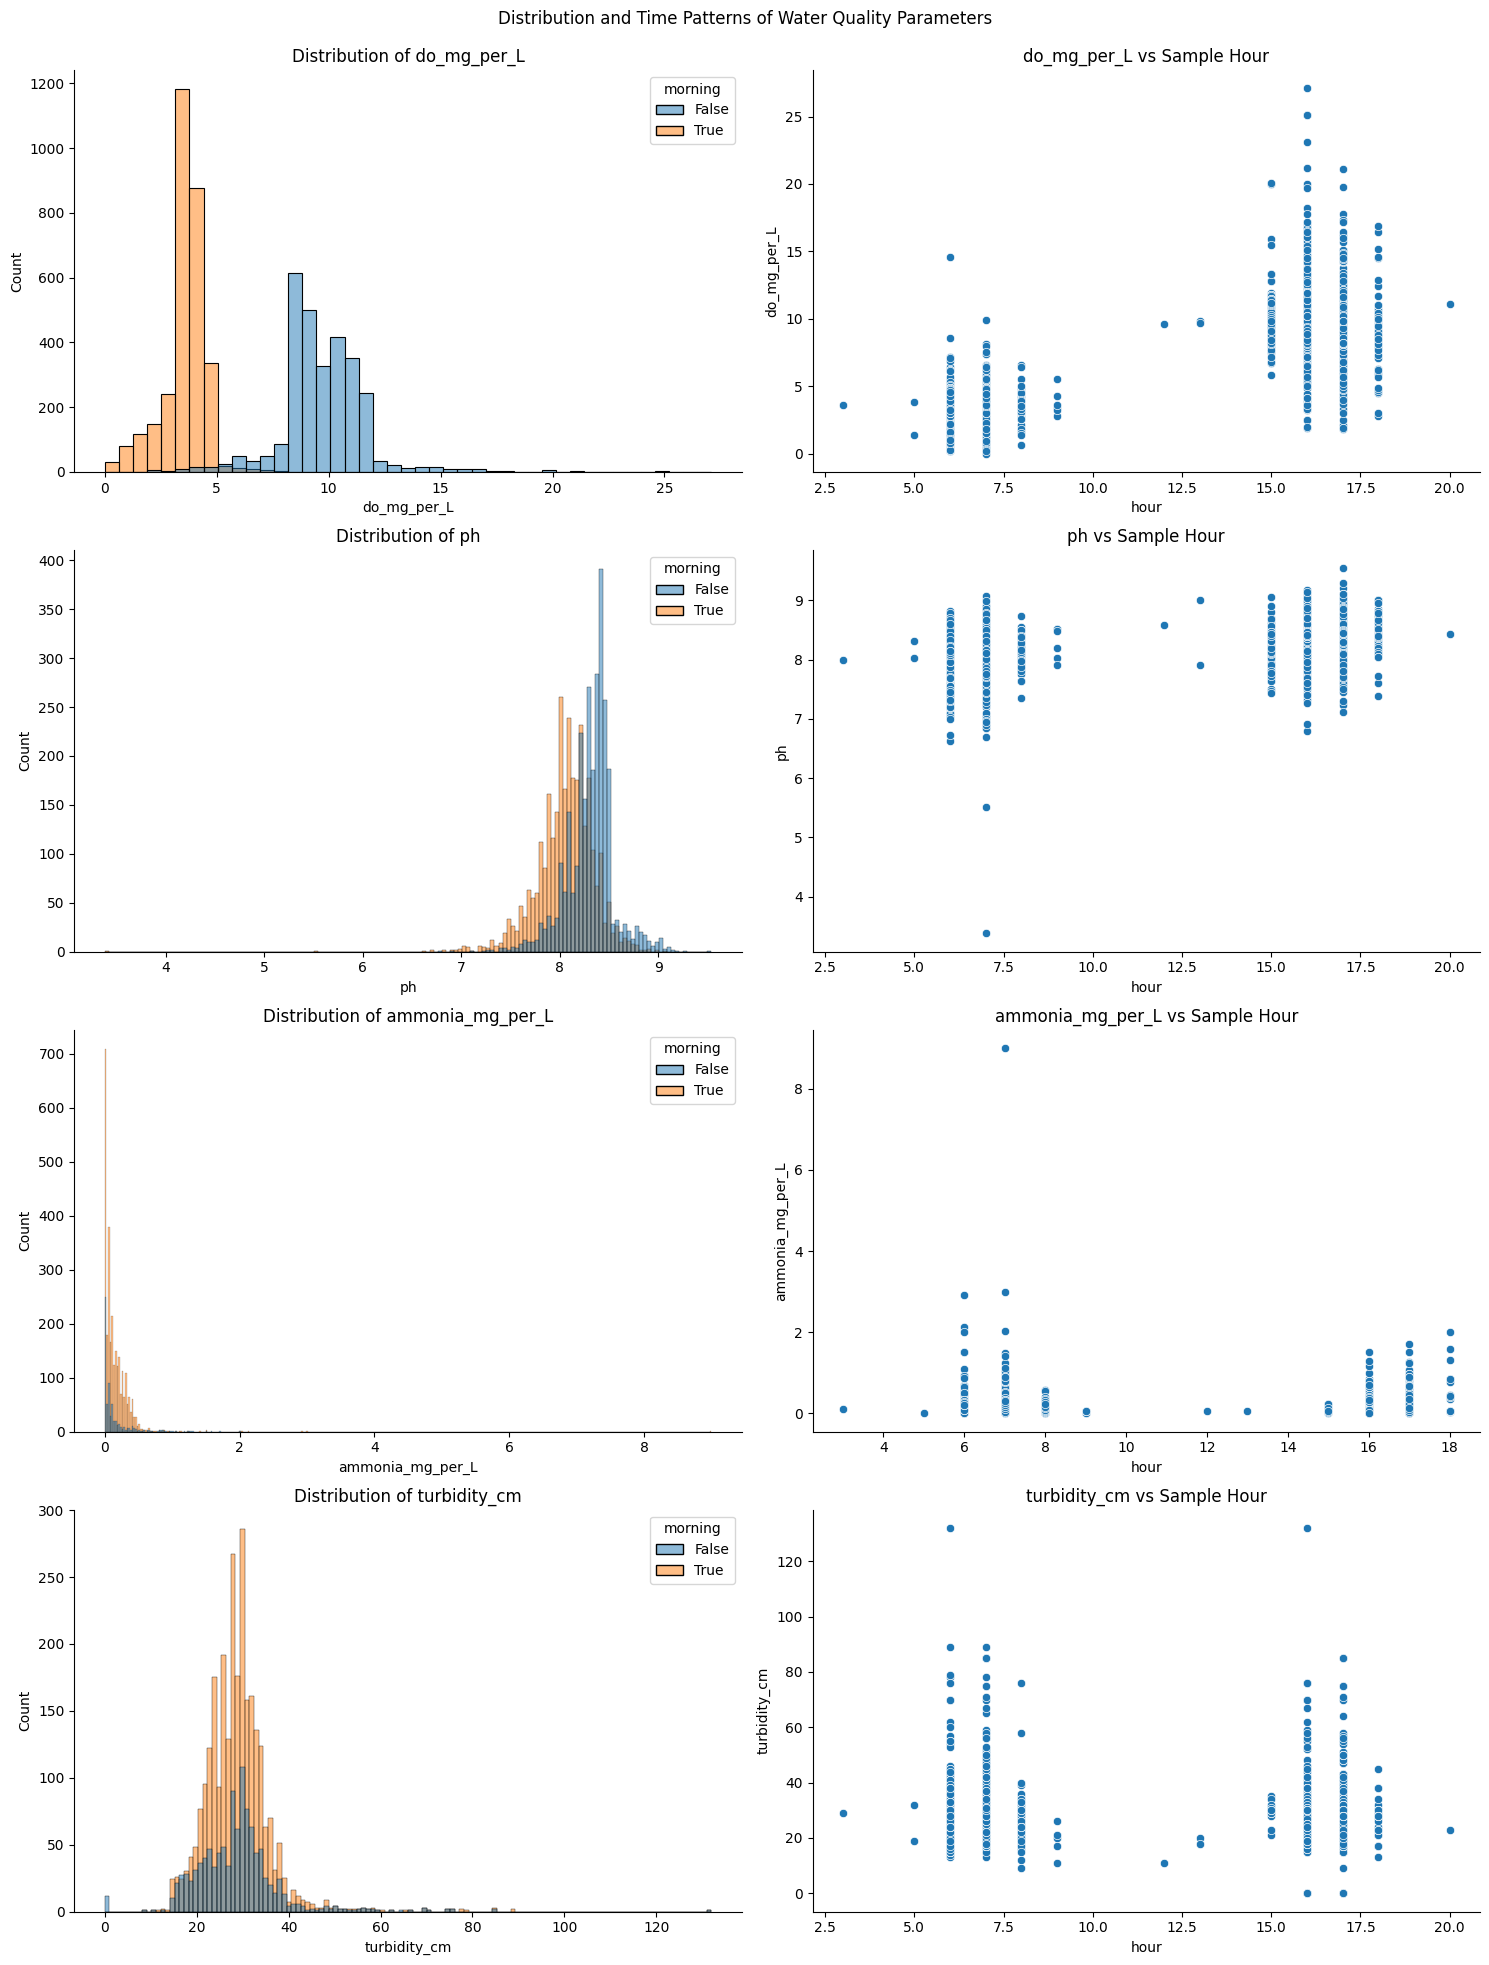

In [73]:
# Create figure with subplots for each outcome variable
outcomes = ['do_mg_per_L', 'ph', 'ammonia_mg_per_L', 'turbidity_cm']

fig, axes = plt.subplots(len(outcomes), 2, figsize=(15, 5*len(outcomes)))

for i, outcome in enumerate(outcomes):
    # Histogram
    sns.histplot(data=explore_ds, x=outcome, hue='morning', ax=axes[i,0])
    axes[i,0].set_title(f'Distribution of {outcome}')
    axes[i,0].spines['top'].set_visible(False)
    axes[i,0].spines['right'].set_visible(False)
    
    # Scatter plot
    sns.scatterplot(data=explore_ds, x='hour', y=outcome, ax=axes[i,1])
    axes[i,1].set_title(f'{outcome} vs Sample Hour')
    axes[i,1].spines['top'].set_visible(False)
    axes[i,1].spines['right'].set_visible(False)

# Add padding between suptitle and subplots
fig.tight_layout()
fig.suptitle('Distribution and Time Patterns of Water Quality Parameters')
fig.subplots_adjust(top=0.95)

In [74]:
explore_ds.loc[explore_ds['turbidity_cm'] == 0, 'tubidity_cm'] = np.nan

In [75]:
explore_ds[explore_ds.duplicated(['pond_id', 'sample_dt'], keep=False)] # No duplicates

,sample_idx,sample_time,pond_id,farmer,is_follow_up_possible,reason_follow_up_not_possible,group,pond_status,observer,measure_instruments,...,prev_weight,prev_species_catla,prev_species_rohu,prev_species_roopchand,prev_species_grass_carp,prev_species_pangasius,prev_species_whiteleg_shrimp,days_since_prev,do_winkler,tubidity_cm


In [76]:
explore_ds['region'] = explore_ds['pond_id'].str[:2]
explore_ds['farm'] = explore_ds['pond_id'].str[:-1]

In [77]:
keep_cols = ['sample_idx', 'sample_dt', 'pond_id', 'region', 'farm', 'morning', 'hour', 'do_mg_per_L', 'ph', 'turbidity_cm',
             'ammonia_mg_per_L', 'do_winkler']
keep_cols = keep_cols + explore_ds.columns[explore_ds.columns.str.contains('prev_')].tolist()

explore_ds = explore_ds[keep_cols].copy()

In [78]:
explore_ds.to_csv("../data/clean/measurements_jun_21_dec_24.csv", index=False)

### Combine with pond metadata

In [79]:
ponds = gpd.read_file("../data/clean/pond_metadata_clean.geojson")

In [80]:
ponds.columns

Index(['pond_serial_no', 'pond_data_date', 'pond_id', 'farmer',
       'enrollment_mechanism', 'culture_change', 'existing_practices',
       'notes_existing_practices', 'fertilizers_used', 'fish_source', 'notes',
       'village', 'added_by', 'property_area_acres', 'pond_area_acres',
       'pond_depth_meters', 'treatment_group', 'measurements', 'equipment',
       'feed_type', 'feed_source', 'feed_brand', 'geometry'],
      dtype='object')

In [81]:
# Clean equipment vars
ponds['has_water_pump'] = ponds['equipment'].astype(str).str.contains('water pump', case=False)
ponds['has_aerator'] = ponds['equipment'].astype(str).str.contains('aerator', case=False)
ponds.loc[ponds['equipment'].astype(str).str.contains('no aerator', case=False), 'has_aerator'] = False
ponds['has_motor_boat'] = ponds['equipment'].astype(str).str.contains('boat', case=False)
ponds['has_sprinkler'] = ponds['equipment'].astype(str).str.contains('sprinkler', case=False)

ponds = ponds.drop(columns='equipment')

In [82]:
ponds['fertilizers_used'].value_counts(dropna=False)

fertilizers_used
None                                                                                                     57
No                                                                                                       25
DAP, Potash, Cow manure                                                                                   9
Manure (cow, pig, horse, poultry or other dung)\nUrea                                                     9
Single super phosphate\nPotash                                                                            8
Urea\nTriple super phosphate                                                                              8
Cow Manure                                                                                                7
Manure (cow, pig, horse, poultry or other dung)\nTriple super phosphate\nPotash                           7
Manure (cow, pig, horse, poultry or other dung)\nTriple super phosphate                                   6
Urea, DAP  

In [83]:
# Fertilizer dummies. Most likely these will lead to overfitting since counts are so low.
ponds['fertilizer_manure'] = ponds['fertilizers_used'].str.contains('manure', case=False)
ponds['fertilizer_dap'] = ponds['fertilizers_used'].str.contains('DAP')
ponds['fertilizer_potash'] = ponds['fertilizers_used'].str.contains('potash', case=False)
ponds['fertilizer_urea'] = ponds['fertilizers_used'].str.contains('urea', case = False)
ponds['fertilizer_phosphate'] = ponds['fertilizers_used'].str.contains('phosphate', case=False)
ponds['fertilizer_amm_sulph'] = ponds['fertilizers_used'].str.contains('ammonium phosphate', case=False)
ponds['fertilizer_probiotics'] = ponds['fertilizers_used'].str.contains('probiotics', case=False)
ponds['fertilizer_magnesium'] = ponds['fertilizers_used'].str.contains('magnesium', case=False)
ponds['fertilizer_gromor'] = ponds['fertilizers_used'].str.contains('gromor', case=False)
ponds['fertilizer_lime'] = ponds['fertilizers_used'].str.contains('lime', case=False)
ponds['fertilizer_none'] = ponds['fertilizers_used'].isin(['None', 'No'])

ponds = ponds.drop(columns='fertilizers_used')

In [84]:
ponds['pond_preparation'] = ponds['existing_practices'].str.contains('pond preparation', case=False)
ponds = ponds.drop(columns='existing_practices')

In [85]:
ponds['village'] = ponds['village'].str.title()

In [86]:
ponds['feed_type'].value_counts()

feed_type
Mash                                         89
Dorb                                         50
Pelleted floating                            29
Pelleted floating, Mash                      24
Unsure                                       17
Pelleted sinking                              5
Pelleted sinking, , DORB                      5
DORB                                          2
Pelleted floating, , DORB                     2
DOB                                           2
DOB, Rice husk                                2
Pelleted sinking, Mash                        1
Mash, Pelleted floating                       1
Pelleted sinking, DOB                         1
Pelleted floating, Pelleted sinking, Mash     1
Pelleted sinking, DOP                         1
Pelleted floating, DOB                        1
Mash, DOB, Rice husk                          1
Mash, DOB                                     1
Pelleted floating, Rice husk                  1
Name: count, dtype: int64

In [87]:
ponds['feed_mash'] = ponds['feed_type'].str.contains('mash', case=False)
ponds['feed_pellets_float'] = ponds['feed_type'].str.contains('pelleted float', case=False)
ponds['feed_pellets_sink'] = ponds['feed_type'].str.contains('pelleted sink', case=False)
ponds['feed_dorb'] = ponds['feed_type'].str.contains('dorb|dob', case=False)
ponds['feed_rice_husk'] = ponds['feed_type'].str.contains('rice husk', case=False)

ponds = ponds.drop(columns='feed_type')

In [88]:
ponds.columns

Index(['pond_serial_no', 'pond_data_date', 'pond_id', 'farmer',
       'enrollment_mechanism', 'culture_change', 'notes_existing_practices',
       'fish_source', 'notes', 'village', 'added_by', 'property_area_acres',
       'pond_area_acres', 'pond_depth_meters', 'treatment_group',
       'measurements', 'feed_source', 'feed_brand', 'geometry',
       'has_water_pump', 'has_aerator', 'has_motor_boat', 'has_sprinkler',
       'fertilizer_manure', 'fertilizer_dap', 'fertilizer_potash',
       'fertilizer_urea', 'fertilizer_phosphate', 'fertilizer_amm_sulph',
       'fertilizer_probiotics', 'fertilizer_magnesium', 'fertilizer_gromor',
       'fertilizer_lime', 'fertilizer_none', 'pond_preparation', 'feed_mash',
       'feed_pellets_float', 'feed_pellets_sink', 'feed_dorb',
       'feed_rice_husk'],
      dtype='object')

In [89]:
pond_cols = ['pond_id', 'property_area_acres', 'pond_area_acres', 'pond_depth_meters', 'geometry',
             'has_water_pump', 'has_aerator', 'has_motor_boat', 'has_sprinkler', 'pond_preparation',
             'village']
pond_cols = pond_cols + ponds.columns[ponds.columns.str.contains('fertilizer_')].tolist()
pond_cols = pond_cols + ponds.columns[ponds.columns.str.contains('feed_')].tolist()

In [90]:
ponds = ponds[pond_cols]
ponds = ponds.drop(columns=['feed_brand', 'feed_source'])
ponds = ponds[ponds['geometry'].notna()]

In [91]:
combined = gpd.GeoDataFrame(
  explore_ds.merge(ponds, on='pond_id', how='inner'), # Inner as we need location
  geometry='geometry',
  crs=ponds.crs
)

In [92]:
combined.columns

Index(['sample_idx', 'sample_dt', 'pond_id', 'region', 'farm', 'morning',
       'hour', 'do_mg_per_L', 'ph', 'turbidity_cm', 'ammonia_mg_per_L',
       'do_winkler', 'prev_matches_time', 'prev_sample_dt', 'prev_do_mg_per_L',
       'prev_ph', 'prev_turbidity_cm', 'prev_ammonia_mg_per_L',
       'prev_individuals_air_gulping', 'prev_individuals_tail_splashing',
       'prev_dead_fish', 'prev_feed_amount_kg',
       'prev_stocking_density_per_acre', 'prev_weight', 'prev_species_catla',
       'prev_species_rohu', 'prev_species_roopchand',
       'prev_species_grass_carp', 'prev_species_pangasius',
       'prev_species_whiteleg_shrimp', 'property_area_acres',
       'pond_area_acres', 'pond_depth_meters', 'geometry', 'has_water_pump',
       'has_aerator', 'has_motor_boat', 'has_sprinkler', 'pond_preparation',
       'village', 'fertilizer_manure', 'fertilizer_dap', 'fertilizer_potash',
       'fertilizer_urea', 'fertilizer_phosphate', 'fertilizer_amm_sulph',
       'fertilizer_probiotic

In [93]:
combined.to_file("../data/clean/jun_21_dec_24_w_metadata.geojson")